In [66]:
from slugify import slugify
import numpy as np
import pandas as pd
import scipy.stats


import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns

import arviz as az
import pymc as pm
import xarray as xr
from pymc import Gamma, Poisson, Exponential, Model

import json

import dcs
import priors
import pgamma

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
ref_prior = (1, 100)

# location data: characteristices of the sensors
bi = pd.read_csv("data/dc_locations.csv")
bi["sensor"] = bi["sensor"].map(lambda x: slugify(x))

# the guesses from the students
guessed = pd.read_csv('data/guesses.csv')

report_name="Lac Léman"
# the column name in the survey data and
# location data where the feature_name will
# be found
feature="feature"
# the region of interest
feature_name="lac-leman"
# retrieve the current data and the most common codes for the region of interest
report_leman, codes = pgamma.get_most_common_and_aggregated_feature_report(report_name=report_name, pg=feature, pgn=feature_name)
# get the report ot the most common codes
dr = report_leman.make_report_code_summary()
# the columns need to be renamed for this usage
de = dr[1:]
di = pd.DataFrame(de)
di.columns = dr[0]
# limit the report to only the codes of interest
di = di[di.Code.isin(codes)]
xi = di[['Code', 'Description', 'N pieces', 'pcs/m','Fail rate']]
# export to .json
x = xi.to_dict(orient="records")
with open("most_common_json.json", "w") as afile:
    json.dump(x, afile)

regional_surveys = ['Tolochenaz',
     'Bourg-en-Lavaux', 
     'Morges', 
     'Allaman', 
     'Lausanne', 
     'Saint-Sulpice (VD)', 
     'Préverenges', 
     'Rolle',
    ]

# the uptodate data for lac leman
eix = pd.read_csv("ei_uptotdate.csv")
eix["date"] = pd.to_datetime(eix["date"])

# the data prior to the sample date
ei = eix[eix["date"] < "2022-10-01"]

# mask for the most common codes
code_mask = (ei.code.isin(codes))

# regressors
variables = ["lake", "grand-lac", 'Saint-Sulpice (VD)']

# the columns of interest
columns = ["pcs_m","quantity", "group", "code", "loc_date", "sensor", *variables]

d = ei[code_mask].copy()

regional_mask = d.city.isin(regional_surveys)

# mask the regional data for the municipal data
city_mask = (d.city == 'Saint-Sulpice (VD)')
# the easiest way to get summary data from IQAASL
# is to use the module for that purpose


## Prior information

### Prior data

The prior data is all survey records on Lake Geneva from 2015 to October 1, 2022.

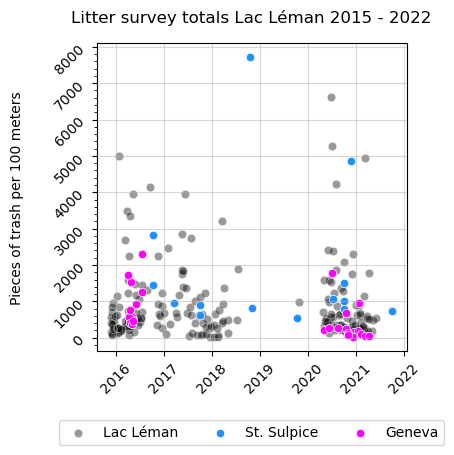

In [68]:
# the survey totals for the lake and Saint Sulpice
# the sum in pcs/100m of each sample since 2015
sp_prior = ei[(ei.city ==  'Saint-Sulpice (VD)')].copy()
g_prior = ei[(ei.city ==  'Genève')].copy()
cdt = sp_prior.groupby(["loc_date", "date", "sensor"], as_index=False).agg({"quantity":"sum", "pcs_m":"sum"})
gdt = g_prior.groupby(["loc_date", "date", "sensor"], as_index=False).agg({"quantity":"sum", "pcs_m":"sum"})
daily_totals = ei.groupby(["loc_date", "date", "sensor"], as_index=False).agg({"quantity":"sum", "pcs_m":"sum"})
fig, ax = plt.subplots(figsize=(4, 4))

daily_totals["date"] = pd.to_datetime(daily_totals["date"])
cdt["date"] =  pd.to_datetime(cdt["date"])
gdt["date"] =  pd.to_datetime(gdt["date"])

sns.scatterplot(data=daily_totals, x="date", y="pcs_m", color="black", alpha=0.4, label="Lac Léman", ax=ax)
sns.scatterplot(data=cdt, x="date", y="pcs_m", color="dodgerblue", label="St. Sulpice", ax=ax)
sns.scatterplot(data=gdt, x="date", y="pcs_m", color="magenta", label="Geneva", ax=ax)
ax.set_ylabel("Pieces of trash per 100 meters", labelpad=20)
ax.set_xlabel(" ")
ax.set_title("Litter survey totals Lac Léman 2015 - 2022", fontsize=12, pad=15)
ax.tick_params(axis="both", which="both", labelsize=10, rotation=45)
ax.legend(bbox_to_anchor=(0.5,-.2), loc="upper center", ncol=3)
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(which='major', axis='both', alpha=0.5)
plt.savefig("survey_totals.png", dpi=300)
plt.show()

### Summary of prior knowledge

We assume that the beach litter survey results are **vectors** that describe the interaction/exchange of trash (all sizes > 0mm) between the survey location and the body of water it borders. *Body of water* refers to areas of reduced current flow in a river basin. For example lake Geneva to the Rhône or Bielersee to the Aare. Therefore, the magnitude of the interaction/exchange is quantified by the rate component of the vector that describes the interaction.  

1. The survey results represent the minimum possible value for an object. It is certain that not all objects that were present at a location were indetified and counted. Furtthermore, objects that are found can be misidentified or the wrong code applied to the record upon data entry.

2. There is a relationship to the number of objects suspended in the body of water and the number of objects that are counted and identitfied in the strand-line at a survey. The number of objects in suspension is unknown.

3. Objects in suspension are trasnported according to the direction of the river basin, surface currents, wind currents and meteorological events. The magnitude of the exchange of objects between the shoreline and the body of water is also influenced by local topography. The magnitued of this exchange is unknown for the lake in general nor for any location in particular.

4. Each location or beach produces/emitts particles that are exchanged with the lake. Those particles get transported according to 3. 

5. Storm water drains, streams, rivers and canals ( hydrologic inputs ) are sources of particles in suspension. The number and size of hydrologic inputs is a factor in the number of particles in suspension for a  body of water.

The magnitude of the *trash* vector on the beach is the result of many interactions. One possible method to forecasting results could include quantifying each interaction term. This would be helpfull information but is not strictly required. From a resource perspective this would require that three additional sources of information (for each quantified interaction) be maintained and accessible for each location so that forecasting could be accomplished. None of which currently exist at a required precision level for any specific location. The question is about the magnitude of the *trash* vector and not any other attribute, for this there is direct evidence. The shortcomings or bias of this evidence is summarized in 1.

The Negative Binomial distribution has been suggested by WRU and the JRC when calculating trend lines using a Generalized Linear Model (GLM) or identifying extreme values from a dataset ( JRC ). The GLM method proposed by WRU use the survey totals and group totals to determine trend lines, with the recomendation to use objects that are indentified frequently. The example in the report is Single Use Plastics (SUPS). This method does not exclude any survey results and is constrained geographically. 

#### Models and priors

**Prior data:** The method proposed by WRU is attractive because of the properties of the NB and its use in evaluating count data in many other fields. We define objects that are *identified frequently* as any object that was found in at least 50% of the surveys or any object with a cumulative total that places them in the top ten most abundant.

**Model:** Given conditions 2-5 we assume that the survey results for the most common objects are NB distributed with parameters $\alpha$ and $\lambda$. $A$ is Exponentialy distributed with parameter $i$ and $\Lambda$ is the result of a linear approximation of $B_{i}, X_{i}$. $B$ is the intercept and $B_{i}$ is the magnitude of the interaction term for the undefined values previously cited. Both are assumed normally disributed for any individual location or region.

$$
\begin{aligned} 
Y  &\sim NB(\lambda, \alpha) \\
\alpha &\sim Exponential(i) \\
\lambda &= B + B_0 X_0 + B_1 X_1 + B_2 X_2 \\
B &\sim  N(\mu, \sigma) \\
B_{i} &\sim N(\mu, \sigma) \\
\end{aligned}
$$

The variance of the survey results increase with the required geographical precision of the assessment. This relationship is in part due to the decreasing number of samples per region or sub region, ie. there are 250  surveys for the lake and only 15 for Saint Sulpice. The average pcs/100m at Saint Sulpice is double that of the lake, while the average of the grand-lac is very close to the lake.

The intended purpose of the model is to allow end users to consult current and predicted values for any number of planning purposes. This includes planning holiday weekends or designing a process that is supposed to reduce trash in the water for a region or body of water. Our conditions of success are focussed on practicallity and implementation. The testing of the model and the results from those tests should be easy to consult and understand. The definitive test should always be a direct comparison between what was found and the forecast. The initial test period should be as long as the baseline collection period. In this case one year.

**Conditions of success:**

1. On average have a better prediction rate than a random guess
2. The forecast describes a compromise between the city and the subregion
3. Predicted values are reasonable compared to historical results
4. The forecast is sensitive to the addition of new information

### Summary of results by region and subregion

The mean pcs/100m of the most common objects indentified for the period 2020-2021.

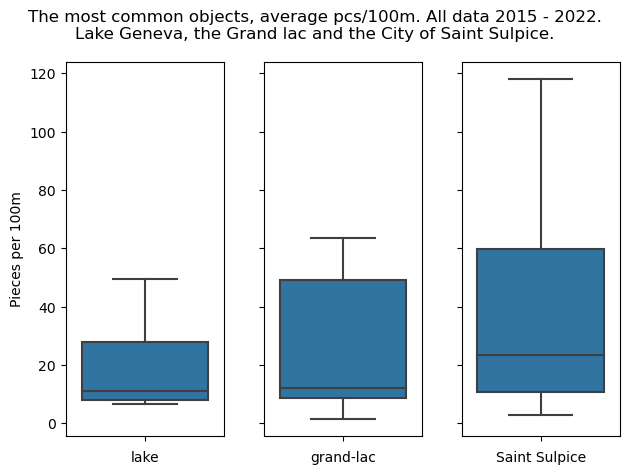

In [74]:
mean_pcode = ei.groupby("code").pcs_m.mean()
def add_group(x, anarray, agroup, akey):
    
    if x in anarray:
        data = agroup
    else:
        data = akey
    return data
    
    
d = ei[ei.code.isin(codes)].copy()
d["mean_c"] = d["code"].map(lambda x: mean_pcode.loc[x])
d["mean_diff"] = d["pcs_m"] - d["mean_c"]
d["mean_diff_sqrd"] = d["mean_diff"]**2
d["root_mean_diff"] = d["mean_diff_sqrd"]**1/2
d["group"] = "lake"
d["group"] = d["city"].map(lambda x: add_group(x, regional_surveys, "grand-lac", "lake"))
# d = d.sort_values(by="pcs_m")

fig, ax = plt.subplots(1,3, sharey=True)


xlabels = ["lake", "grand-lac", "Saint Sulpice"]

ax1 = ax[0]
ax2 = ax[1]
ax3 = ax[2]



done = d.groupby("code", as_index=False)["pcs_m"].mean()
dtwo = d[d.group == "grand-lac"].groupby("code", as_index=False)["pcs_m"].mean()
dthree = d[d.city == 'Saint-Sulpice (VD)'].groupby("code", as_index=False)["pcs_m"].mean()

for i, anax in enumerate([ax1, ax2, ax3]):
    anax.set_xlabel(xlabels[i])



sns.boxplot(data=done, y="pcs_m",  showfliers=False, ax=ax1)
sns.boxplot(data=dtwo, y="pcs_m",  showfliers=False, ax=ax2)
sns.boxplot(data=dthree, y="pcs_m",  showfliers=False, ax=ax3)


for anax in [ax2, ax3]:
    anax.set_ylabel(" ")


title_one = "The most common objects, average pcs/100m. All data 2015 - 2022."
title_two = "Lake Geneva, the Grand lac and the City of Saint Sulpice."

ax1.set_ylabel("Pieces per 100m")
plt.suptitle(f"{title_one}\n{title_two}")
plt.tight_layout()
plt.savefig("most_common_objects_regional_av.jpeg", dpi=300)
plt.show()

In [44]:
fsummaries = f"""

Summary lake:
{done.pcs_m.describe()}

Summary grand-lac:
{dtwo.pcs_m.describe()}

Summary Saint Sulpice:
{dthree.pcs_m.describe()}

        """
print(fsummaries)



Summary lake:
count     24.000000
mean      31.535408
std       42.438795
min        6.548000
25%        8.115635
50%       11.080321
75%       28.043173
max      138.600000
Name: pcs_m, dtype: float64

Summary grand-lac:
count     24.000000
mean      37.606043
std       53.132503
min        1.576271
25%        8.529661
50%       12.284483
75%       48.983051
max      219.600000
Name: pcs_m, dtype: float64

Summary Saint Sulpice:
count     24.000000
mean      65.941270
std       95.544651
min        2.857143
25%       10.767857
50%       23.535714
75%       59.732143
max      345.733333
Name: pcs_m, dtype: float64

        


### Implementing the model in PyMC

In [45]:
comb2 = comb[[ "pcs_m",	"lake", "pierrettes"]].copy()
comb2["lake"] = True

c2 = {"regressor": ["pierrettes"], "obs_idx":comb2.index}

with pm.Model(coords=c2) as LakeModelX:
    
    a = pm.Normal("intercept", mu=0, sigma=5)
    b = pm.Normal("slopes", mu=0, sigma=1, dims="regressor")
    alpha = pm.Exponential("alpha", 1)
    
    
    C = pm.ConstantData("pierrettes", comb2.pierrettes.to_numpy(), dims="obs_idx")    

    λ =pm.Deterministic("param", pm.math.exp(a + b[0]*C ), dims="obs_idx")
    y = pm.NegativeBinomial("found", mu=λ, alpha=alpha, observed= comb2.pcs_m.to_numpy(), dims="obs_idx")

    sampled_r = pm.sample(1000, tune=1000)
    pm.sample_posterior_predictive(sampled_r,extend_inferencedata=True, random_seed=rng)

NameError: name 'comb' is not defined

In [46]:
def summary_percode(code, results):
    d = results[code][0]
    e = az.summary(d, var_names=["intercept", "slopes"], kind='stats')
    v = np.exp(e)
    vi = v.product(axis=0)
    vi["code"] = code
    vi["predicted-mean"] = results[code][0].posterior_predictive.found.mean().to_numpy().item()
    return vi

def collect_summaries(codes, results, location):
    
    vis = []
    for code in codes:
        f = summary_percode(code, results)
        f["location"] = location
        vis.append(f)
    return vis


def select_for_a_code(code, data):    
    d = data[data.code == code][["pcs_m", "sensor", *variables]].copy()
    d.reset_index(inplace=True, drop = True)
    return d



def add_location_column(location, data):
    data[location] = False
    data.loc[data['sensor'] == location, location] = True
    return data

def make_a_glm(location, data):
    
    c2 = {"regressor": [location, "city","region:lake"], "obs_idx":data.index}

    with pm.Model(coords=c2) as LakeModelX:
        a = pm.Normal("intercept", mu=0, sigma=1)
        b = pm.Normal("slopes", mu=0, sigma=1, dims="regressor")
        alpha = pm.Exponential("alpha", 1)

        
        C = pm.ConstantData(location, data[location].to_numpy(), dims="obs_idx")
        D = pm.ConstantData("city", data['Saint-Sulpice (VD)'].to_numpy(), dims="obs_idx")
        E = pm.ConstantData("region",  data["grand-lac"].to_numpy(), dims="obs_idx")
        F = pm.ConstantData("lake",  data["lake"].to_numpy(), dims="obs_idx")
        
        λ =pm.Deterministic("param", pm.math.exp(a + b[0]*C + b[1]*D + b[2]*F*E), dims="obs_idx")
        
        y = pm.NegativeBinomial("found", mu=λ, alpha=alpha, observed=data.pcs_m.to_numpy(), dims="obs_idx")

        sampled_r = pm.sample(1000, tune=1000)
        pm.sample_posterior_predictive(sampled_r,extend_inferencedata=True, random_seed=rng)
        
        return sampled_r, LakeModelX

def make_predictions(locations, codes, data):
    
    results = {}
    for loc in locations:
        r = {loc:{}}
        for code in codes:
            dtx = select_for_a_code(code, data)
            
            d = add_location_column(loc, dtx)
           
            sampled, model = make_a_glm(loc, d)
            r[loc].update({code:[sampled, model]})
        results.update(r)
    
    return results, d


d = ei[code_mask].copy()
 
d["lake"] = True
d[variables[1]] = regional_mask
d[variables[2]] = city_mask

combined = d.copy()    

In [47]:
abeach = "parc-des-pierrettes"
aregion = 'Saint-Sulpice (VD)'
xhp = make_predictions([abeach], codes, combined)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [8]:
abeach = "plage-de-st-sulpice"
xh = make_predictions([abeach], codes, combined)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [48]:
# posterior dist and model parc-des-pierretts
h, hmodel = xhp
# posterior dist and model plage-de-st-sulpice
f, fmodel = xh

### Model results

There is a small difference in the mean value between one beach and the other.

In [49]:
asummary = np.exp(az.summary(h["parc-des-pierrettes"]["Gfrags"][0], var_names=["intercept", "slopes"], kind='stats'))
asummary

,mean,sd,hdi_3%,hdi_97%
intercept,109.071104,1.104066,91.286234,132.026149
slopes[parc-des-pierrettes],0.526765,2.003709,0.146900,1.946436
slopes[city],2.042144,1.485869,0.970446,4.353587
slopes[region:lake],1.670295,1.249821,1.089806,2.514314


In [50]:
asummary = np.exp(az.summary(f["plage-de-st-sulpice"]["Gfrags"][0], var_names=["intercept", "slopes"], kind='stats'))
asummary

,mean,sd,hdi_3%,hdi_97%
intercept,109.071104,1.107383,91.286234,133.486453
slopes[plage-de-st-sulpice],0.712482,1.873859,0.208253,2.131871
slopes[city],2.031958,1.484384,0.978240,4.349235
slopes[region],1.675313,1.246077,1.104066,2.504277
slopes[lake],1.015113,2.759363,0.151223,6.692584


### Guessed versus predicted

The forecasted values have a lower sum of squared diffences ( $\sum \sqrt{(y_{predicted} - y_{found})²}$ ) than the guessed values ( $\sum \sqrt{(y_{guessed} - y_{found})²}$ ).

In [51]:
summary_columns = ['mean', 'sd', 'hdi_3%', 'hdi_97%', 'code', 'predicted-mean', 'location']

b = collect_summaries(codes, h['parc-des-pierrettes'], 'parc-des-pierrettes')
g = collect_summaries(codes, f['plage-de-st-sulpice'], 'plage-de-st-sulpice')

ppps = pd.concat(b, axis=1).T
pdp = ppps[summary_columns].copy()

pspg = pd.concat(g, axis=1).T
psp = pspg[summary_columns].copy()

predictions =  pd.concat([psp, pdp])
predictions["location"] = predictions["location"].map(lambda x:  f"{x}-predicted")

gsd = pd.read_csv("guessed_combined.csv")
gsd.rename(columns={"beach":"sensor"}, inplace=True)
gsd = gsd.sort_values(by="code")

eixd = eix[(eix["date"] > "2022-10-01") & (eix.code.isin(combined.code.unique()))].copy()
eixd["sensor"] = eixd.sensor.map(lambda x: f"{x}-found")
eixd["pcs_m"] = (eixd.quantity/41)*100
eixd = eixd.sort_values(by="code")

predictions = predictions.sort_values(by="code")
predictions.rename(columns={"location":"sensor"}, inplace=True)

# make maps to found and guessed values
def select_and_aggregate_records(data, location, column):
    d = data[data.sensor == location].groupby("code").pcs_m.mean()
    return d

def make_amap_to_found_code_values(data, location):
    d = data[eixd.sensor == location][["code", "pcs_m"]].set_index("code", drop=True)
    return d["pcs_m"]

def add_guessed_found_column(d, amap, col_name):
    d[col_name] = d.code.map(lambda x: amap.loc[x])
    return d

def the_difference_between_guessed_predicted(d):
    d["guessed-diff"] = d["guessed"] - d["found"]
    d["predicted-diff"] = d["predicted-mean"] - d["found"]
    return d

def the_diiference_squared(d, location, guess_map, found_map):
    
    data = d[d.sensor == location].copy()
    data = add_guessed_found_column(data,  guess_map, "guessed")
    data = add_guessed_found_column(data, found_map, "found")
    data = the_difference_between_guessed_predicted(data)
    data["abs_guessed"] = data["guessed-diff"].abs()
    data["abs_predicted"] =data["predicted-diff"].abs()
    data["guessed <= predicted"] = data["abs_guessed"] <= data["abs_predicted"]
       
    return data
    
# the predicted, guessed and found quantities for each beach
# plage de st sulpice
gsp = select_and_aggregate_records(gsd,"plage-de-st-sulpice-guessed", "code")
exf_ps = make_amap_to_found_code_values(eixd,  "plage-de-st-sulpice-found")
pred_sp = the_diiference_squared(predictions,  "plage-de-st-sulpice-predicted", gsp, exf_ps) 

# parc des pierrettes
exf_pp = make_amap_to_found_code_values(eixd,  "parc-des-pierrettes-found")
gpp = select_and_aggregate_records(gsd, "parc-des-pierrettes-guessed", "code")
pred_pp = the_diiference_squared(predictions,  'parc-des-pierrettes-predicted', gpp, exf_pp) 

# a quick comparison of the sum of the differences
dif_summPP=pred_pp[["abs_guessed", "abs_predicted"]].sum()
dif_summSP=pred_sp[["abs_guessed", "abs_predicted"]].sum()

# format and export results
x1 = pred_pp[['code', 'predicted-mean', 'guessed', 'found', "guessed-diff", "predicted-diff"]].to_dict(orient="records")
x2 = pred_sp[['code', 'predicted-mean', 'guessed', 'found', "guessed-diff", "predicted-diff"]].to_dict(orient="records")

with open("guessed_predicted_found_pp.json", "w") as afile:
    json.dump(x1, afile)
with open("guessed_predicted_found_ps.json", "w") as afile:
    json.dump(x2, afile)

In [52]:
# the sum of the abosolute value (distance) of guessed or predicted - found
print("parc-des-pierrettes")
print(dif_summPP)
print("plage-de-st-sulpice")
print(dif_summSP)

parc-des-pierrettes
abs_guessed      1504.485095
abs_predicted     736.966351
dtype: object
plage-de-st-sulpice
abs_guessed      1524.216028
abs_predicted        859.123
dtype: object


The number of $guessed <= predicted$ is 10/48 or 80% of the mean forecasted values were closer than the guessed values

In [53]:
# the number of times that the difference of guessed - found was less than or equal to predicted
print("parc-des-pierrettes")

print(f"guessed <= predicted: {pred_pp['guessed <= predicted'].sum()}")

print("plage-de-st-sulpice")
print(f"guessed <= predicted:{pred_sp['guessed <= predicted'].sum()}")


parc-des-pierrettes
guessed <= predicted: 5
plage-de-st-sulpice
guessed <= predicted:5


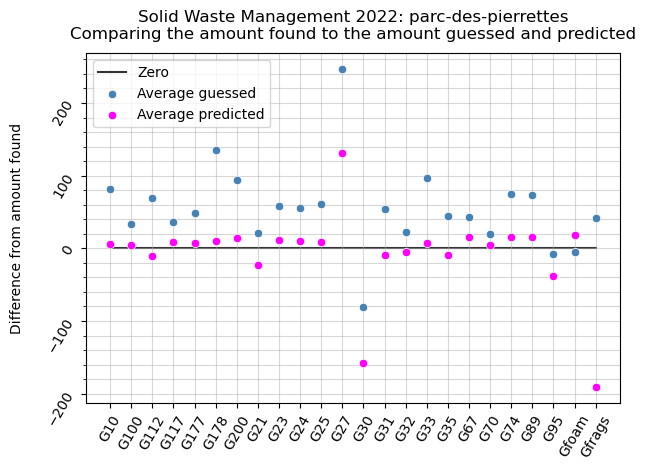

In [80]:
fig, ax = plt.subplots()


data = pred_pp[["code", "found", "guessed-diff", "predicted-diff"]].copy()
x= data["code"].values
y=data["guessed-diff"].values
y2 = data["predicted-diff"].values

y_sqd = np.sqrt(y**2)
y2_sqd = y2**2

ty = [np.sqrt(x) for x in y2_sqd]

xmax = len(x)
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(20))
ax.grid(which='both', axis='both', alpha=0.5)
sns.lineplot(x=x, y=np.zeros(len(x)), color="black", alpha=0.8, label="Zero", zorder=0)
sns.scatterplot(x=x, y=y, label = "Average guessed", color="steelblue", ax=ax, zorder=2)
sns.scatterplot(x=x, y=y2, label = "Average predicted", color="magenta", ax=ax, zorder=2)

ax.tick_params(axis="both", which="both", labelsize=10, rotation=60)
ax.set_ylabel("Difference from amount found", labelpad=15)
ax.set_title("Solid Waste Management 2022: parc-des-pierrettes\nComparing the amount found to the amount guessed and predicted", pad=10)
ax.legend(bbox_to_anchor=(0,1), loc="upper left")


plt.tight_layout()
plt.savefig("differences_predicted_guessed_pp.jpeg", dpi=300)
plt.show()

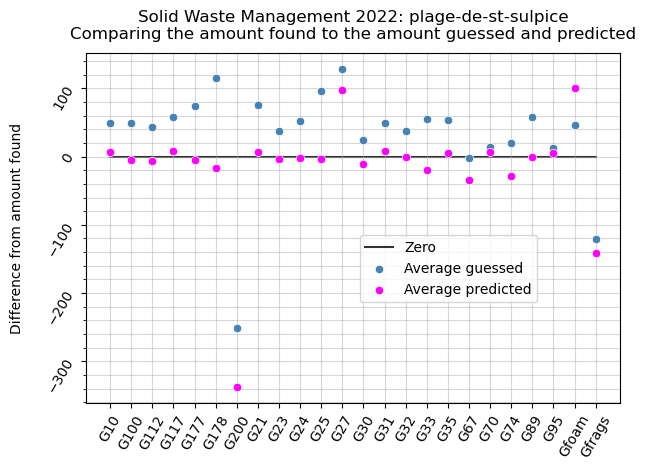

In [83]:
fig, ax = plt.subplots()


data = pred_sp[["code", "found", "guessed-diff", "predicted-diff"]].copy()
x= data["code"].values
y=data["guessed-diff"].values
y2 = data["predicted-diff"].values

y_sqd = np.sqrt(y**2)
y2_sqd = y2**2

ty = [np.sqrt(x) for x in y2_sqd]

xmax = len(x)
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(20))
ax.grid(which='both', axis='both', alpha=0.5)

sns.lineplot(x=x, y=np.zeros(len(x)), color="black", alpha=0.8, label="Zero", zorder=0)
sns.scatterplot(x=x, y=y, label = "Average guessed", color="steelblue", ax=ax, zorder=2)
sns.scatterplot(x=x, y=y2, label = "Average predicted", color="magenta", ax=ax, zorder=2)

ax.tick_params(axis="both", which="both", labelsize=10, rotation=60)
ax.set_ylabel("Difference from amount found", labelpad=15)
ax.set_title("Solid Waste Management 2022: plage-de-st-sulpice\nComparing the amount found to the amount guessed and predicted", pad=10)
ax.legend(bbox_to_anchor=(.5,.5), loc="upper left")
ax.grid(which='major', axis='both', alpha=0.5)
plt.tight_layout()
plt.savefig("differences_predicted_guessed_sp.jpeg", dpi=300)
plt.show()

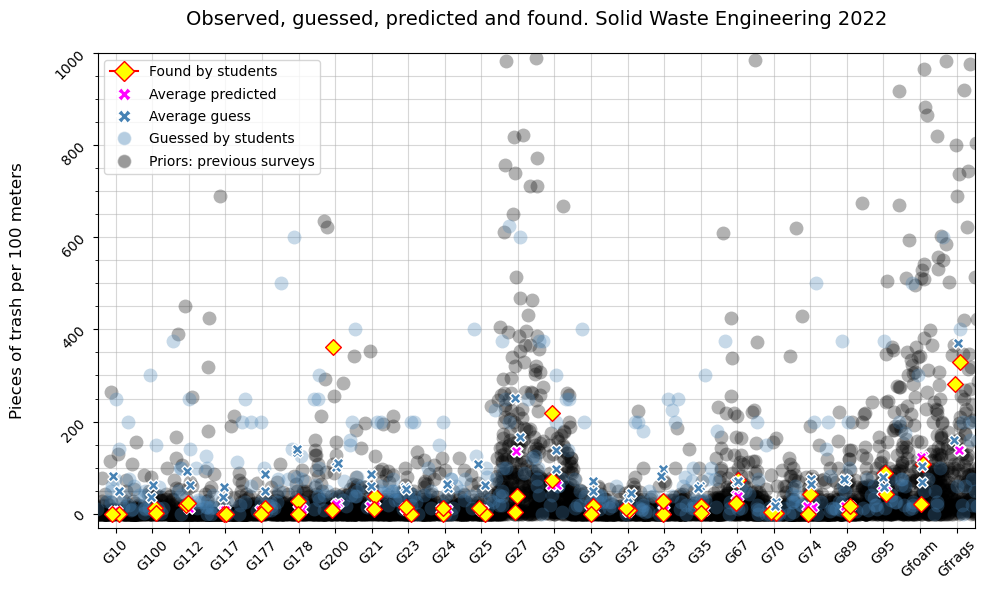

In [84]:
fig, ax = plt.subplots(figsize=(10,6))

g_mean = gsd.groupby(["sensor", "code"], as_index=False).pcs_m.mean()


legend_elements = [Line2D([0], [0], marker="D", color='red', markerfacecolor='yellow', markersize=10, label='Found by students'),
                   Line2D([0], [0], marker='X', color='white', label='Average predicted', markerfacecolor='magenta', markersize=10),
                    Line2D([0], [0], marker='X', color='white', label='Average guess', markerfacecolor='steelblue', markersize=10),
                    Line2D([0], [0], marker='o', markerfacecolor='steelblue', color='w',label='Guessed by students', markersize=10, alpha=0.4),
                   Line2D([0], [0], marker='o', markerfacecolor='black', color='w',label='Priors: previous surveys', markersize=10, alpha=0.4),
                 ]
                  
               
sns.stripplot(data=combined, x="code", y="pcs_m", color="black", label="all_values", alpha=0.3, ax=ax, jitter=.6, size=10)
sns.stripplot(data=gsd, x="code", y="pcs_m", color="steelblue", alpha=0.3, ax=ax, jitter=.6, size=10)


sns.stripplot(data=predictions, x="code", y="predicted-mean",  size=8, edgecolor="white", color="magenta", marker="X", linewidth=1, ax=ax)
sns.stripplot(data=eixd, x="code", y="pcs_m", size=8, edgecolor="red", color="yellow", linewidth=1,  marker="D",  ax=ax)

sns.stripplot(data=g_mean, y="pcs_m", x="code", size=8, edgecolor="white", color="steelblue", marker="X", linewidth=1, ax=ax)

ax.tick_params(axis="both", which="both", labelsize=10, rotation=45)
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(50))
ax.grid(which='both', axis='both', alpha=0.5)

ax.set_title("Observed, guessed, predicted and found. Solid Waste Engineering 2022", fontsize=14, pad=20)
ax.set_ylabel("Pieces of trash per 100 meters", labelpad=20, fontsize=12)
ax.set_xlabel("")
ax.set_ylim(-30, 1000)
ax.get_legend().remove()
ax.grid(which='both', axis='y', alpha=0.5)

ax.legend(handles=legend_elements, loc='upper left', labelspacing=.6)
plt.tight_layout()

plt.savefig("results.jpg", dpi=300)
plt.show()

In [85]:
combined.groupby("code").pcs_m.mean()

code
G10         6.630522
G100        6.847390
G112       15.955823
G117        8.947791
G177        7.216867
G178       10.738956
G200       24.124498
G21        16.309237
G23        11.421687
G24        10.709677
G25         9.000000
G27       137.746988
G30        62.598394
G31         7.634538
G32         6.548000
G33         7.425703
G35         8.276000
G67        39.799197
G70        10.200803
G74        15.181452
G89        16.729839
G95        49.606426
Gfoam     128.600000
Gfrags    138.600000
Name: pcs_m, dtype: float64

In [18]:
code_mask = (eix.code.isin(codes))
e = eix[code_mask].copy()

regional_mask = e.city.isin(regional_surveys)

# mask the regional data for the municipal data
city_mask = (e.city == 'Saint-Sulpice (VD)')
e["lake"] = True
e[variables[1]] = regional_mask
e[variables[2]] = city_mask

In [19]:
abeach = "parc-des-pierrettes"
aregion = 'Saint-Sulpice (VD)'
updtd_pp = make_predictions([abeach], codes, e)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [20]:
abeach = "plage-de-st-sulpice"
updated_sp = make_predictions([abeach], codes, e)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [21]:
tpp, tpp_model = updtd_pp

asummary = np.exp(az.summary(tpp["parc-des-pierrettes"]["Gfrags"][0], var_names=["intercept", "slopes"], kind='stats'))
asummary

,mean,sd,hdi_3%,hdi_97%
intercept,108.962087,1.102963,90.017131,129.411856
slopes[parc-des-pierrettes],0.621263,1.885136,0.186934,2.031958
slopes[city],2.017784,1.460823,0.947432,3.982859
slopes[region],1.680346,1.247323,1.114048,2.552313
slopes[lake],1.015113,2.734641,0.145584,6.116561


In [22]:
tsp, tsp_model = updated_sp
asummary = np.exp(az.summary(tsp["plage-de-st-sulpice"]["Gfrags"][0], var_names=["intercept", "slopes"], kind='stats'))
asummary

,mean,sd,hdi_3%,hdi_97%
intercept,109.289465,1.104066,90.287588,131.236364
slopes[plage-de-st-sulpice],0.728331,1.775354,0.253346,2.174938
slopes[city],2.023847,1.481418,0.966572,4.166182
slopes[region],1.666957,1.246077,1.106277,2.526917
slopes[lake],0.991040,2.721001,0.150619,6.391698


In [23]:
summary_columns = ['mean', 'sd', 'hdi_3%', 'hdi_97%', 'code', 'predicted-mean', 'location']

b = collect_summaries(codes, tpp['parc-des-pierrettes'], 'parc-des-pierrettes')
g = collect_summaries(codes, tsp['plage-de-st-sulpice'], 'plage-de-st-sulpice')

tppx = pd.concat(b, axis=1).T
tpps = tppx[summary_columns].copy()

tpspx = pd.concat(g, axis=1).T
tpsp = tpspx[summary_columns].copy()

upd_pred =  pd.concat([tpsp, tpps])
upd_pred["location"] = upd_pred["location"].map(lambda x:  f"{x}-predicted")
upd_pred.rename(columns={"location":"sensor"}, inplace=True)
upd_pred.sort_values(by="code", inplace=True)


upd_sp = the_diiference_squared(upd_pred,  "plage-de-st-sulpice-predicted", gsp, exf_ps) 


upd_pp = the_diiference_squared(upd_pred,  'parc-des-pierrettes-predicted', gpp, exf_pp) 

# a quick comparison of the sum of the differences
dif_summPP=upd_pp[["abs_guessed", "abs_predicted"]].sum()
dif_summSP=upd_sp[["abs_guessed", "abs_predicted"]].sum()

In [24]:
# the sum of the abosolute value (distance) of guessed or predicted - found
print("parc-des-pierrettes")
print(dif_summPP)
print("plage-de-st-sulpice")
print(dif_summSP)

parc-des-pierrettes
abs_guessed      1504.485095
abs_predicted     729.654606
dtype: object
plage-de-st-sulpice
abs_guessed      1524.216028
abs_predicted     855.878832
dtype: object


In [25]:
# the number of times that the difference of guessed - found was less than or equal to predicted
print("parc-des-pierrettes")

print(f"guessed <= predicted: {upd_pp['guessed <= predicted'].sum()}")

print("plage-de-st-sulpice")
print(f"guessed <= predicted:{upd_sp['guessed <= predicted'].sum()}")


parc-des-pierrettes
guessed <= predicted: 5
plage-de-st-sulpice
guessed <= predicted:5


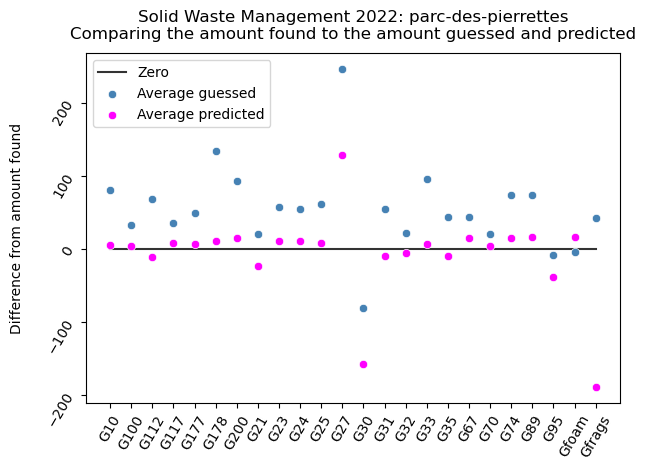

In [26]:
fig, ax = plt.subplots()


data = upd_pp[["code", "found", "guessed-diff", "predicted-diff"]].copy()
x= data["code"].values
y=data["guessed-diff"].values
y2 = data["predicted-diff"].values

y_sqd = np.sqrt(y**2)
y2_sqd = y2**2

ty = [np.sqrt(x) for x in y2_sqd]

xmax = len(x)

sns.lineplot(x=x, y=np.zeros(len(x)), color="black", alpha=0.8, label="Zero", zorder=0)
sns.scatterplot(x=x, y=y, label = "Average guessed", color="steelblue", ax=ax, zorder=2)
sns.scatterplot(x=x, y=y2, label = "Average predicted", color="magenta", ax=ax, zorder=2)

ax.tick_params(axis="both", which="both", labelsize=10, rotation=60)
ax.set_ylabel("Difference from amount found", labelpad=15)
ax.set_title("Solid Waste Management 2022: parc-des-pierrettes\nComparing the amount found to the amount guessed and predicted", pad=10)
ax.legend(bbox_to_anchor=(0,1), loc="upper left")
plt.tight_layout()
plt.savefig("differences_predicted_guessed_pp.jpeg", dpi=300)
plt.show()

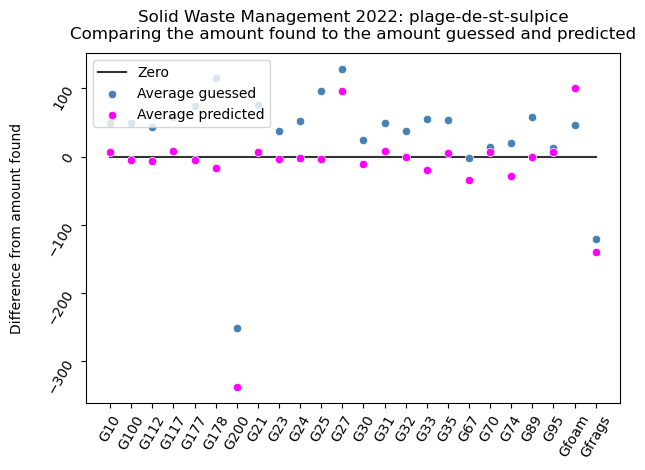

In [27]:
fig, ax = plt.subplots()


data = upd_sp[["code", "found", "guessed-diff", "predicted-diff"]].copy()
x= data["code"].values
y=data["guessed-diff"].values
y2 = data["predicted-diff"].values

y_sqd = np.sqrt(y**2)
y2_sqd = y2**2

ty = [np.sqrt(x) for x in y2_sqd]

xmax = len(x)

sns.lineplot(x=x, y=np.zeros(len(x)), color="black", alpha=0.8, label="Zero", zorder=0)
sns.scatterplot(x=x, y=y, label = "Average guessed", color="steelblue", ax=ax, zorder=2)
sns.scatterplot(x=x, y=y2, label = "Average predicted", color="magenta", ax=ax, zorder=2)

ax.tick_params(axis="both", which="both", labelsize=10, rotation=60)
ax.set_ylabel("Difference from amount found", labelpad=15)
ax.set_title("Solid Waste Management 2022: plage-de-st-sulpice\nComparing the amount found to the amount guessed and predicted", pad=10)
ax.legend(bbox_to_anchor=(0,1), loc="upper left")
plt.tight_layout()
plt.savefig("differences_predicted_guessed_pp.jpeg", dpi=300)
plt.show()

In [28]:
def make_a_glm(location, data):
    
    c2 = {"regressor": [location, "city", "region"], "intercepts":["r"], "obs_idx":data.index}

    with pm.Model(coords=c2) as LakeModelX:
        a = pm.Normal("intercept", mu=0, sigma=1, dims="intercepts")
        b = pm.Normal("slopes", mu=0, sigma=1, dims="regressor")
        alpha = pm.Exponential("alpha", 1)

        
        C = pm.ConstantData(location, data[location].to_numpy(), dims="obs_idx")
        D = pm.ConstantData("city", data['Saint-Sulpice (VD)'].to_numpy(), dims="obs_idx")
        E = pm.ConstantData("region",  data["grand-lac"].to_numpy(), dims="obs_idx")
        O = pm.ConstantData("observed", data["pcs_m"].to_numpy(), dims="obs_idx")
        
        
        λ =pm.Deterministic("param", pm.math.exp(a*E + b[0]*C + b[1]*D), dims="obs_idx")
        
        y = pm.NegativeBinomial("found", mu=λ, alpha=alpha, observed=O, dims="obs_idx")

        sampled_r = pm.sample(1000, tune=1000)
        pm.sample_posterior_predictive(sampled_r,extend_inferencedata=True, random_seed=rng)
        
        return sampled_r, LakeModelX

def make_predictions(locations, codes, data):
    
    results = {}
    for loc in locations:
        r = {loc:{}}
        for code in codes:
            dtx = select_for_a_code(code, data)
            
            d = add_location_column(loc, dtx)
           
            sampled, model = make_a_glm(loc, d)
            r[loc].update({code:[sampled, model]})
        results.update(r)
    
    return results, d

abeach = "parc-des-pierrettes"
aregion = 'Saint-Sulpice (VD)'
newd = e[e["grand-lac"] == True].copy()
no_lakepp = make_predictions([abeach], codes, newd)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [29]:
abeach = "plage-de-st-sulpice"
no_lakesp = make_predictions([abeach], codes, newd)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [30]:
nlpp, nlpp_model = no_lakepp
nlsp, nlsp_model = no_lakesp

asummary = np.exp(az.summary(nlpp["parc-des-pierrettes"]["Gfrags"][0], var_names=["intercept", "slopes"], kind='stats'))
asummary

,mean,sd,hdi_3%,hdi_97%
intercept[r],156.178565,1.190056,112.617824,216.372184
slopes[parc-des-pierrettes],0.605319,1.798585,0.204743,1.879489
slopes[city],2.339647,1.421909,1.247323,4.697357
slopes[region],1.010050,2.715565,0.163164,6.679212


In [31]:
asummary = np.exp(az.summary(nlsp[ "plage-de-st-sulpice"]["Gfrags"][0], var_names=["intercept", "slopes"], kind='stats'))
asummary

,mean,sd,hdi_3%,hdi_97%
intercept[r],155.399621,1.190056,113.295562,217.456754
slopes[plage-de-st-sulpice],0.714623,1.743684,0.257689,2.089657
slopes[city],2.363161,1.437636,1.259859,4.845256
slopes[region],1.019182,2.753850,0.167294,7.463317


In [96]:
az.summary(nlsp[ "plage-de-st-sulpice"]["Gfrags"][0], var_names=["intercept", "slopes"], kind='stats')

,mean,sd,hdi_3%,hdi_97%
intercept[r],5.046,0.174,4.730,5.382
slopes[plage-de-st-sulpice],-0.336,0.556,-1.356,0.737
slopes[city],0.860,0.363,0.231,1.578
slopes[region],0.019,1.013,-1.788,2.010


In [32]:
summary_columns = ['mean', 'sd', 'hdi_3%', 'hdi_97%', 'code', 'predicted-mean', 'location']

b = collect_summaries(codes, nlpp['parc-des-pierrettes'], 'parc-des-pierrettes')
g = collect_summaries(codes, nlsp['plage-de-st-sulpice'], 'plage-de-st-sulpice')

tppnlx = pd.concat(b, axis=1).T
tppsln = tppnlx[summary_columns].copy()

tpsnlx = pd.concat(g, axis=1).T
tpspln = tpsnlx[summary_columns].copy()

nl_pred =  pd.concat([tpspln, tppsln])
nl_pred["location"] = nl_pred["location"].map(lambda x:  f"{x}-predicted")
nl_pred.rename(columns={"location":"sensor"}, inplace=True)
nl_pred.sort_values(by="code", inplace=True)


nl_sp = the_diiference_squared(nl_pred,  "plage-de-st-sulpice-predicted", gsp, exf_ps) 

nl_pp = the_diiference_squared(nl_pred,  'parc-des-pierrettes-predicted', gpp, exf_pp) 

# a quick comparison of the sum of the differences
dif_summPPnl=nl_pp[["abs_guessed", "abs_predicted"]].sum()
dif_summSPnl=nl_sp[["abs_guessed", "abs_predicted"]].sum()

In [33]:
# the sum of the abosolute value (distance) of guessed or predicted - found
print("parc-des-pierrettes")
print(dif_summPPnl)
print("plage-de-st-sulpice")
print(dif_summSPnl)

parc-des-pierrettes
abs_guessed      1504.485095
abs_predicted     647.149876
dtype: object
plage-de-st-sulpice
abs_guessed      1524.216028
abs_predicted     766.079085
dtype: object


In [34]:
# the number of times that the difference of guessed - found was less than or equal to predicted
print("parc-des-pierrettes")

print(f"guessed <= predicted: {nl_pp['guessed <= predicted'].sum()}")

print("plage-de-st-sulpice")
print(f"guessed <= predicted:{nl_sp['guessed <= predicted'].sum()}")


parc-des-pierrettes
guessed <= predicted: 5
plage-de-st-sulpice
guessed <= predicted:5


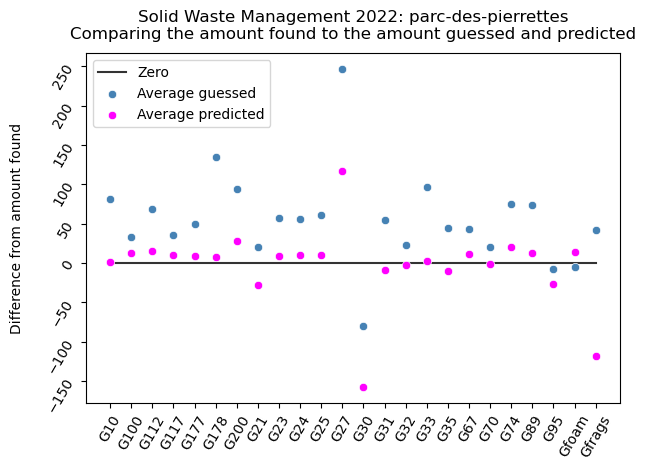

In [35]:
fig, ax = plt.subplots()


data = nl_pp[["code", "found", "guessed-diff", "predicted-diff"]].copy()
x= data["code"].values
y=data["guessed-diff"].values
y2 = data["predicted-diff"].values

y_sqd = np.sqrt(y**2)
y2_sqd = y2**2

ty = [np.sqrt(x) for x in y2_sqd]

xmax = len(x)

sns.lineplot(x=x, y=np.zeros(len(x)), color="black", alpha=0.8, label="Zero", zorder=0)
sns.scatterplot(x=x, y=y, label = "Average guessed", color="steelblue", ax=ax, zorder=2)
sns.scatterplot(x=x, y=y2, label = "Average predicted", color="magenta", ax=ax, zorder=2)

ax.tick_params(axis="both", which="both", labelsize=10, rotation=60)
ax.set_ylabel("Difference from amount found", labelpad=15)
ax.set_title("Solid Waste Management 2022: parc-des-pierrettes\nComparing the amount found to the amount guessed and predicted", pad=10)
ax.legend(bbox_to_anchor=(0,1), loc="upper left")
plt.tight_layout()
plt.savefig("differences_predicted_guessed_ppnl.jpeg", dpi=300)
plt.show()

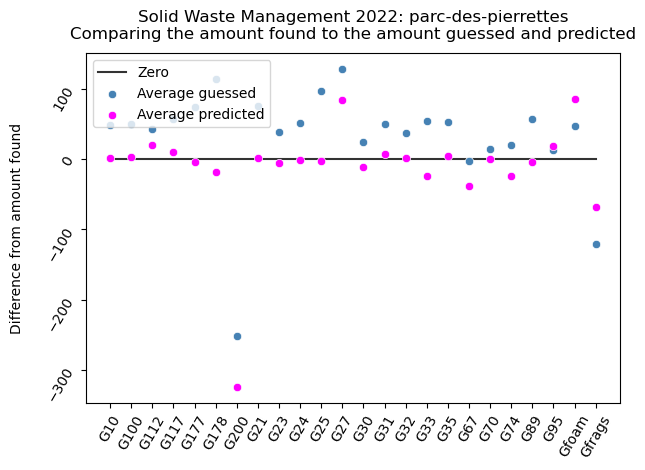

In [36]:
fig, ax = plt.subplots()


data = nl_sp[["code", "found", "guessed-diff", "predicted-diff"]].copy()
x= data["code"].values
y=data["guessed-diff"].values
y2 = data["predicted-diff"].values

y_sqd = np.sqrt(y**2)
y2_sqd = y2**2

ty = [np.sqrt(x) for x in y2_sqd]

xmax = len(x)

sns.lineplot(x=x, y=np.zeros(len(x)), color="black", alpha=0.8, label="Zero", zorder=0)
sns.scatterplot(x=x, y=y, label = "Average guessed", color="steelblue", ax=ax, zorder=2)
sns.scatterplot(x=x, y=y2, label = "Average predicted", color="magenta", ax=ax, zorder=2)

ax.tick_params(axis="both", which="both", labelsize=10, rotation=60)
ax.set_ylabel("Difference from amount found", labelpad=15)
ax.set_title("Solid Waste Management 2022: parc-des-pierrettes\nComparing the amount found to the amount guessed and predicted", pad=10)
ax.legend(bbox_to_anchor=(0,1), loc="upper left")
plt.tight_layout()
plt.savefig("differences_predicted_guessed_spnl.jpeg", dpi=300)
plt.show()

In [37]:
def collect_predicted_and_predicted_diff(data, forecast_number):
    cols = ["code", "predicted-mean", "predicted-diff"]
    data["forecast"] = forecast_number
    changed = data[[*cols, "forecast"]].copy()
    
    return changed
    

def the_difference_between_updates(forecasts):
    
    new = []
    for i,aset in enumerate(forecasts):
        collected = collect_predicted_and_predicted_diff(aset, i+1)
        new.append(collected)
    
    d = pd.concat(new).set_index("code")
    x = d[d.forecast == 1]["predicted-mean"] - d[d.forecast == 2]["predicted-mean"]
    
    
    return x
    
    

n = the_difference_between_updates([nl_sp, pred_sp])
q = the_difference_between_updates([nl_pp, pred_pp])

<AxesSubplot:xlabel='found / found'>

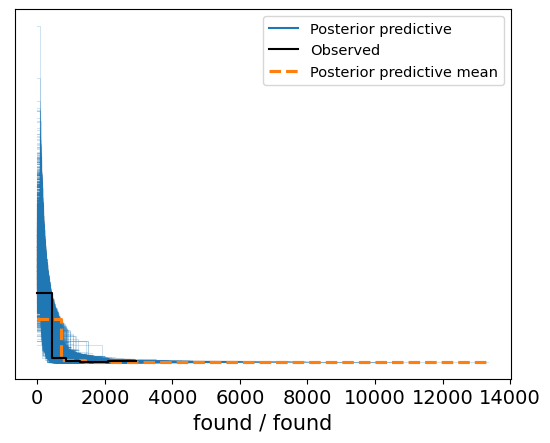

In [198]:
az.plot_ppc(jx)

In [224]:
combined.head()

,loc_date,date,sensor,feature,city,code,quantity,pcs_m,lake,grand-lac,Saint-Sulpice (VD),samps
1,"('anarchy-beach', '2018-04-02')",2018-04-02,anarchy-beach,lac-leman,La Tour-de-Peilz,G10,4,6.0,True,False,False,2
2,"('anarchy-beach', '2018-04-02')",2018-04-02,anarchy-beach,lac-leman,La Tour-de-Peilz,G100,10,14.0,True,False,False,2
14,"('anarchy-beach', '2018-04-02')",2018-04-02,anarchy-beach,lac-leman,La Tour-de-Peilz,G112,0,0.0,True,False,False,2
19,"('anarchy-beach', '2018-04-02')",2018-04-02,anarchy-beach,lac-leman,La Tour-de-Peilz,G117,0,0.0,True,False,False,2
76,"('anarchy-beach', '2018-04-02')",2018-04-02,anarchy-beach,lac-leman,La Tour-de-Peilz,G177,2,3.0,True,False,False,2


In [229]:
ndx =  newd[["sensor", "city", "code", "pcs_m"]].copy()
ndx.reset_index(inplace=True)
ndx.index

RangeIndex(start=0, stop=1465, step=1)

In [226]:
pd.factorize(newd.city)

(array([0, 0, 0, ..., 5, 5, 5]),
 Index(['Tolochenaz', 'Bourg-en-Lavaux', 'Morges', 'Allaman', 'Lausanne',
        'Saint-Sulpice (VD)', 'Préverenges', 'Rolle'],
       dtype='object'))

In [276]:
# county_idxs, counties = pd.factorize(data.county)
# coords = {
#     "county": counties,
#     "obs_id": np.arange(len(county_idxs)),
# }



# with pm.Model(coords=coords) as hierarchical_model:
#     county_idx = pm.Data("county_idx", county_idxs, dims="obs_id")
#     # Hyperpriors for group nodes
#     mu_a = pm.Normal("mu_a", mu=0.0, sigma=100)
#     sigma_a = pm.HalfNormal("sigma_a", 5.0)
#     mu_b = pm.Normal("mu_b", mu=0.0, sigma=100)
#     sigma_b = pm.HalfNormal("sigma_b", 5.0)

#     # Intercept for each county, distributed around group mean mu_a
#     # Above we just set mu and sd to a fixed value while here we
#     # plug in a common group distribution for all a and b (which are
#     # vectors of length n_counties).
#     a = pm.Normal("a", mu=mu_a, sigma=sigma_a, dims="county")
#     # effect difference between basement and floor level
#     b = pm.Normal("b", mu=mu_b, sigma=sigma_b, dims="county")

#     # Model error
#     eps = pm.HalfCauchy("eps", 5.0)

#     radon_est = a[county_idx] + b[county_idx] * data.floor.values

#     # Data likelihood
#     radon_like = pm.Normal(
#         "radon_like", mu=radon_est, sigma=eps, observed=data.log_radon, dims="obs_id"
#     )



# coords = {"Level": ["Basement", "Floor"]}

# with pm.Model(coords=coords, rng_seeder=RANDOM_SEED) as partial_pooling:
#     county_idx = pm.Data("county_idx", county, dims="obs_id", mutable=True)
#     # Hyperpriors:
#     a = pm.Normal("a", mu=0.0, sigma=10.0)
#     sigma_a = pm.Exponential("sigma_a", 1.0)

#     # Varying intercepts:
#     a_county = pm.Normal("a_county", mu=a, sigma=sigma_a, dims="County")

#     # Expected value per county:
#     theta = a_county[county_idx]
#     # Model error:
#     sigma = pm.Exponential("sigma", 1.0)

#     y = pm.Normal("y", theta, sigma=sigma, observed=log_radon, dims="obs_id")
# pm.model_to_graphviz(partial_pooling)



def assign_region(x, arg, label):
    if x == arg:
        d = label
    else:
        d = "other"
    return d






coords = {"group": ["region", "other"]
}

data = ndx[ndx.code == "G95"].copy()
data["region"] = data.city.map(lambda x: assign_region(x,  'Saint-Sulpice (VD)', "region"))
reg_idx, regs = pd.factorize(data.region)

with pm.Model(coords=coords) as lake_modelx2:
    group_idx = pm.Data("group_idx", reg_idx, dims="obs_id", mutable=True)
    
   
    a_group = pm.Normal("a_group", mu=20, sigma=5, dims="group")
    alpha = pm.Exponential("alpha", 1, dims="obs_id")
    # Varying slopes:
    # b_city = pm.Normal("b_city", mu=20, sigma=5, dims="cit_idx")
    
    

#     C = pm.ConstantData(location, data[location].to_numpy(), dims="obs_idx")
#     D = pm.ConstantData("city", data['Saint-Sulpice (VD)'].to_numpy(), dims="obs_idx")
#     E = pm.ConstantData("region",  data["grand-lac"].to_numpy(), dims="obs_idx")
    # O = pm.ConstantData("observed", data["pcs_m"].to_numpy(), dims="obs_idx")
    
    
    
    λ =pm.Deterministic("param", pm.math.exp(a_group[group_idx]))
    y = pm.NegativeBinomial("found", mu=λ, alpha=alpha, observed=data.pcs_m.values, dims="obs_id")

    sampled_r = pm.sample(1000, tune=1000)
    pm.sample_posterior_predictive(sampled_r,extend_inferencedata=True, random_seed=rng)

    



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_group, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


In [279]:
np.exp(az.summary(sampled_r, var_names="a_group", kind="stats"))

,mean,sd,hdi_3%,hdi_97%
a_group[region],46.852295,1.187678,33.314742,63.624588
a_group[other],81.941043,1.364789,46.618619,149.008001


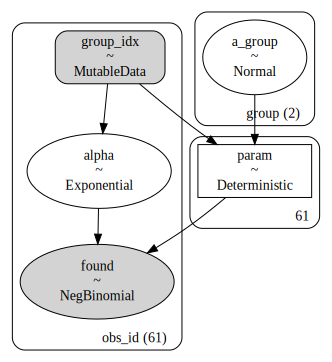

In [278]:
pm.model_to_graphviz(lake_modelx2)

In [283]:
data[data.region == "other"].pcs_m.mean()

56.355555555555554

In [281]:
data[data.region != "other"].pcs_m.mean()

81.775

In [282]:
sampled_r.posterior_predictive.found.mean()

<xarray.DataArray 'found' ()>
array(57.33070492)

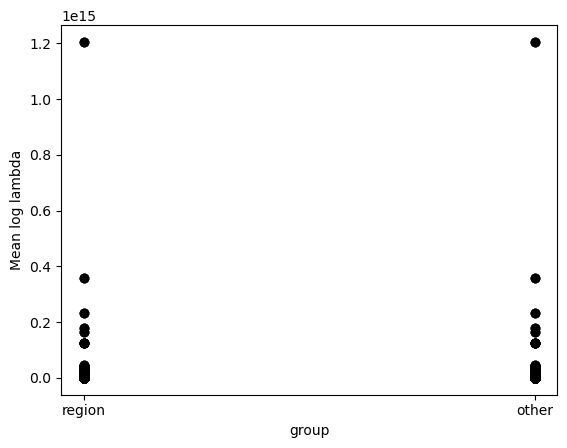

In [287]:
with lake_modelx2:
    prior_checks = pm.sample_prior_predictive()

_, ax = plt.subplots()
prior_checks.prior.plot.scatter(x="group", y="param", color="k", alpha=0.2, ax=ax)
ax.set_ylabel("Mean log lambda");

In [288]:
sampled_r

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [289]:
hdi_helper = lambda ds: az.hdi(ds, input_core_dims=[["chain", "draw", "obs_id"]])
hdi_ppc = (
    sampled_r.posterior_predictive.found.groupby(sampled_r.constant_data.group_idx)
    .apply(hdi_helper)
    .found
)
hdi_ppc


<xarray.DataArray 'found' (group_idx: 2, hdi: 2)>
array([[  0., 143.],
       [  0., 265.]])
Coordinates:
  * hdi        (hdi) <U6 'lower' 'higher'
  * group_idx  (group_idx) int64 0 1

In [91]:
newd[newd[ 'Saint-Sulpice (VD)'] == True].groupby("code").pcs_m.mean()

code
G10         2.500000
G100       32.318750
G112       22.450000
G117       44.312500
G177       10.818750
G178        9.018750
G200      142.100000
G21        22.506250
G23        16.006250
G24        15.406667
G25         7.756250
G27       135.337500
G30       116.981250
G31        10.812500
G32        19.888235
G33         3.331250
G35         6.470588
G67        36.543750
G70         4.875000
G74        42.826667
G89        34.546667
G95        81.775000
Gfoam     300.423529
Gfrags    340.941176
Name: pcs_m, dtype: float64

In [94]:
nl_sp[["code", "predicted-mean"]]

,code,predicted-mean
22,G10,1.840311
0,G100,15.126561
12,G112,39.32459
20,G117,10.773299
1,G177,8.756754
17,G178,7.991836
5,G200,36.204053
21,G21,11.011947
18,G23,9.044574
6,G24,10.72055


In [105]:
nsamps = combined.groupby("sensor").loc_date.nunique()
combined["samps"] = combined.sensor.map(lambda x: nsamps.loc[x])
std_combined = combined.groupby("code").pcs_m.std()
gthree = combined["samps"] >= 3


ndthree = combined[gthree].copy()

std_ndthree = ndthree.groupby("code", as_index=False).pcs_m.std()
std_ndthree["lake"] = std_ndthree.code.map(lambda x: std_combined.loc[x])
std_ndthree["diff"] = std_ndthree["pcs_m"] - std_ndthree["lake"]

In [106]:
std_ndthree

,code,pcs_m,lake,diff
0,G10,23.620754,22.762626,0.858128
1,G100,15.295954,14.826714,0.469240
2,G112,86.308902,83.053726,3.255176
3,G117,55.318780,53.249122,2.069657
4,G177,11.881547,12.175181,-0.293634
5,G178,16.268686,18.011201,-1.742515
6,G200,60.807056,70.927585,-10.120529
7,G21,38.229745,37.665933,0.563811
8,G23,22.170604,23.030898,-0.860294
9,G24,17.800209,18.783779,-0.983570


In [110]:
sndthree = ndthree.groupby(["sensor", "code"]).pcs_m.std()
sndthree.loc["quai-maria-belgia"]

code
G10        11.517820
G100        6.205883
G112        0.639602
G117       57.023729
G177        6.725927
G178        9.466391
G200       23.471453
G21        21.359680
G23        21.290609
G24         8.353137
G25        21.539504
G27       477.665248
G30        76.450604
G31        14.933619
G32         6.023044
G33         9.319718
G35        10.159017
G67        50.154653
G70        10.130854
G74        25.369478
G89        18.334612
G95        55.870851
Gfoam     130.490624
Gfrags     83.695762
Name: pcs_m, dtype: float64

In [116]:
sndthm = ndthree.groupby(["sensor", "code"]).pcs_m.mean()
sndthm.loc["quai-maria-belgia"]

code
G10         5.772727
G100        5.318182
G112        0.136364
G117       29.090909
G177        7.000000
G178        9.772727
G200       20.636364
G21        11.954545
G23        13.363636
G24         7.181818
G25        13.954545
G27       357.772727
G30        70.863636
G31        13.818182
G32         3.909091
G33         7.000000
G35        13.409091
G67        32.818182
G70         8.590909
G74        11.090909
G89        13.409091
G95        37.136364
Gfoam      85.227273
Gfrags     67.863636
Name: pcs_m, dtype: float64

In [111]:
sndthree.loc["maladaire"]

code
G10         3.677473
G100        2.380476
G112        3.104528
G117        0.000000
G177        3.098387
G178       10.682875
G200       10.446234
G21         7.952238
G23         7.539104
G24         8.861366
G25         9.185911
G27        58.829617
G30        47.469991
G31         4.570089
G32         5.300494
G33         1.956674
G35         9.096310
G67        32.686534
G70         8.776592
G74        19.058057
G89        12.824084
G95        34.506452
Gfoam     150.127977
Gfrags     71.564157
Name: pcs_m, dtype: float64

In [112]:
sndthree.loc["preverenges"]

code
G10         1.859044
G100        2.138090
G112      147.807288
G117       56.122120
G177        5.326690
G178       11.926745
G200        1.069045
G21         7.909168
G23        12.839029
G24        12.233084
G25         7.456835
G27       119.579667
G30        49.182548
G31         2.893722
G32         1.888368
G33         2.293086
G35         6.911131
G67        24.638039
G70         1.743118
G74        19.514998
G89         8.643425
G95        21.886445
Gfoam      60.966213
Gfrags    120.215740
Name: pcs_m, dtype: float64

In [115]:
locations = combined[combined.city == 'Saint-Sulpice (VD)'].sensor.unique()

combined[combined.sensor.isin(["parc-des-pierrettes"])].groupby("code").pcs_m.std()

code
G10         3.304038
G100       23.865945
G112       12.000000
G117        1.000000
G177       13.304135
G178        1.500000
G200       33.689761
G21         3.304038
G23         7.071068
G24         2.753785
G25        30.528675
G27        65.592174
G30        31.075178
G31         9.215024
G32         3.862210
G33         4.163332
G35         2.000000
G67        21.802141
G70         1.892969
G74        37.000000
G89        26.424421
G95        47.024816
Gfoam     235.611792
Gfrags    109.027519
Name: pcs_m, dtype: float64

In [138]:
jk = nlpp["parc-des-pierrettes"]["Gfrags"][0].posterior_predictive
jx = nlpp["parc-des-pierrettes"]["Gfrags"][0]

array([ 127,    1,   47, ..., 1156,  545,    7])

In [197]:
az.plot_ppc(jk)

TypeError: `data` argument must have the group "posterior_predictive" for ppcplot

<AxesSubplot:xlabel='y / y'>

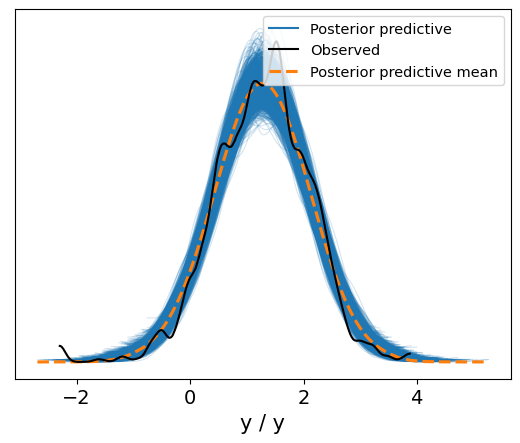

In [158]:
import arviz as az
data = az.load_arviz_data('radon')
az.plot_ppc(data, data_pairs={"y":"y"})

In [182]:
data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [165]:
data.posterior["County"]

<xarray.DataArray 'County' (County: 85)>
array(['AITKIN', 'ANOKA', 'BECKER', 'BELTRAMI', 'BENTON', 'BIG STONE',
       'BLUE EARTH', 'BROWN', 'CARLTON', 'CARVER', 'CASS', 'CHIPPEWA',
       'CHISAGO', 'CLAY', 'CLEARWATER', 'COOK', 'COTTONWOOD', 'CROW WING',
       'DAKOTA', 'DODGE', 'DOUGLAS', 'FARIBAULT', 'FILLMORE', 'FREEBORN',
       'GOODHUE', 'HENNEPIN', 'HOUSTON', 'HUBBARD', 'ISANTI', 'ITASCA',
       'JACKSON', 'KANABEC', 'KANDIYOHI', 'KITTSON', 'KOOCHICHING',
       'LAC QUI PARLE', 'LAKE', 'LAKE OF THE WOODS', 'LE SUEUR', 'LINCOLN',
       'LYON', 'MAHNOMEN', 'MARSHALL', 'MARTIN', 'MCLEOD', 'MEEKER',
       'MILLE LACS', 'MORRISON', 'MOWER', 'MURRAY', 'NICOLLET', 'NOBLES',
       'NORMAN', 'OLMSTED', 'OTTER TAIL', 'PENNINGTON', 'PINE', 'PIPESTONE',
       'POLK', 'POPE', 'RAMSEY', 'REDWOOD', 'RENVILLE', 'RICE', 'ROCK',
       'ROSEAU', 'SCOTT', 'SHERBURNE', 'SIBLEY', 'ST LOUIS', 'STEARNS',
       'STEELE', 'STEVENS', 'SWIFT', 'TODD', 'TRAVERSE', 'WABASHA', 'WADENA',
       'WASECA', 'WASHINGTON', 'WATONWAN', 'WILKIN', 'WINONA', 'WRIGHT',
       'YELLOW MEDICINE'], dtype=object)
Coordinates:
  * County   (County) object 'AITKIN' 'ANOKA' ... 'WRIGHT' 'YELLOW MEDICINE'

In [179]:
data.posterior["County"]

<xarray.DataArray 'County' (County: 85)>
array(['AITKIN', 'ANOKA', 'BECKER', 'BELTRAMI', 'BENTON', 'BIG STONE',
       'BLUE EARTH', 'BROWN', 'CARLTON', 'CARVER', 'CASS', 'CHIPPEWA',
       'CHISAGO', 'CLAY', 'CLEARWATER', 'COOK', 'COTTONWOOD', 'CROW WING',
       'DAKOTA', 'DODGE', 'DOUGLAS', 'FARIBAULT', 'FILLMORE', 'FREEBORN',
       'GOODHUE', 'HENNEPIN', 'HOUSTON', 'HUBBARD', 'ISANTI', 'ITASCA',
       'JACKSON', 'KANABEC', 'KANDIYOHI', 'KITTSON', 'KOOCHICHING',
       'LAC QUI PARLE', 'LAKE', 'LAKE OF THE WOODS', 'LE SUEUR', 'LINCOLN',
       'LYON', 'MAHNOMEN', 'MARSHALL', 'MARTIN', 'MCLEOD', 'MEEKER',
       'MILLE LACS', 'MORRISON', 'MOWER', 'MURRAY', 'NICOLLET', 'NOBLES',
       'NORMAN', 'OLMSTED', 'OTTER TAIL', 'PENNINGTON', 'PINE', 'PIPESTONE',
       'POLK', 'POPE', 'RAMSEY', 'REDWOOD', 'RENVILLE', 'RICE', 'ROCK',
       'ROSEAU', 'SCOTT', 'SHERBURNE', 'SIBLEY', 'ST LOUIS', 'STEARNS',
       'STEELE', 'STEVENS', 'SWIFT', 'TODD', 'TRAVERSE', 'WABASHA', 'WADENA',
       'WASECA', 'WASHINGTON', 'WATONWAN', 'WILKIN', 'WINONA', 'WRIGHT',
       'YELLOW MEDICINE'], dtype=object)
Coordinates:
  * County   (County) object 'AITKIN' 'ANOKA' ... 'WRIGHT' 'YELLOW MEDICINE'

In [180]:
data.constant_data["county_idx"]

<xarray.DataArray 'county_idx' (obs_id: 919)>
array([ 0,  0,  0, ..., 83, 84, 84], dtype=int32)
Coordinates:
  * obs_id   (obs_id) int64 0 1 2 3 4 5 6 7 ... 911 912 913 914 915 916 917 918

In [183]:
jx.posterior["regressor"][0][jx.constant_data["county_idx"]]

<xarray.DataArray 'regressor' (regressor: 3)>
array(['parc-des-pierrettes', 'city', 'region'], dtype='<U19')
Coordinates:
  * regressor  (regressor) <U19 'parc-des-pierrettes' 'city' 'region'

In [184]:
jx

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [193]:
obs_county = jx.posterior["regressor"][0]
# data = data.assign_coords(obs_id=obs_county, groups="observed_vars")
# az.plot_ppc(data, coords={'obs_id': ['ANOKA', 'BELTRAMI']}, flatten=[])

In [194]:
obs_county

<xarray.DataArray 'regressor' (regressor: 3)>
array(['parc-des-pierrettes', 'city', 'region'], dtype='<U19')
Coordinates:
  * regressor  (regressor) <U19 'parc-des-pierrettes' 'city' 'region'